In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from data_factory import holiday_dates
import os
import time

root_path = os.getcwd()
result_path = 'results/'
log_path = 'logs/'
data_path = 'data/'

In [3]:
dt_names = ['electricity_demand', 'wind_plant']

dt_name = dt_names[1]

target = 'prod'  if dt_name == 'wind_plant' else 'demand'

train_df = pd.read_csv(data_path + f'{dt_name}/train.csv', index_col=0)
future_df = pd.read_csv(data_path + f'{dt_name}/test.csv', index_col=0)

train_df['datetime'] = pd.to_datetime(train_df['datetime'])
future_df['datetime'] = pd.to_datetime(future_df['datetime'])

train_df['year'] = train_df['datetime'].dt.year.values
train_df['week'] = train_df['datetime'].dt.isocalendar().week.values
train_df['weekday'] = train_df['datetime'].dt.weekday.values
train_df['month'] = train_df['datetime'].dt.month.values
train_df['day'] = train_df['datetime'].dt.dayofyear.values
train_df['hour'] = train_df['datetime'].dt.hour.values
train_df['date'] = train_df['datetime'].dt.date

train_df['is_holiday'] = train_df['datetime'].dt.date.isin(holiday_dates).astype(float)

In [4]:
train_df.duplicated().sum()

0

In [5]:
train_df.drop_duplicates(inplace=True)
train_df.reset_index(inplace=True, drop=True)     

In [6]:

date_range = pd.date_range(train_df['datetime'].min(), train_df['datetime'].max(), freq='H')
n_missing = len(date_range) - len(train_df)

if n_missing != 0:
    print(f">>> {n_missing} records are missing, which will be filled with interpolation")
    train_df.set_index('datetime', inplace=True)
    new_df = pd.DataFrame(np.nan, index = date_range, columns = train_df.columns)
    new_df.index.name = 'datetime'
    new_df.loc[train_df.index] = train_df.values
    train_df = new_df.interpolate().reset_index()

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         26304 non-null  datetime64[ns]
 1   temp             26304 non-null  float64       
 2   humidity         26304 non-null  int64         
 3   dewPoint         26304 non-null  float64       
 4   appTemp          26304 non-null  float64       
 5   precipitation    26304 non-null  float64       
 6   pressure         26304 non-null  float64       
 7   surfacePressure  26304 non-null  float64       
 8   cloudCover       26304 non-null  int64         
 9   windSpeed10m     26304 non-null  float64       
 10  windSpeed100m    26304 non-null  float64       
 11  windDir10m       26304 non-null  int64         
 12  windDir100m      26304 non-null  int64         
 13  windGusts10m     26304 non-null  float64       
 14  prod             26304 non-null  float

In [8]:
train_df.describe()

,temp,humidity,dewPoint,appTemp,precipitation,pressure,surfacePressure,cloudCover,windSpeed10m,windSpeed100m,...,windDir100m,windGusts10m,prod,year,week,weekday,month,day,hour,is_holiday
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,...,26304.000000,26304.000000,26304.000000,26304.000000,26304.0,26304.000000,26304.000000,26304.000000,26304.000000,26304.0
mean,8.953250,61.684459,0.467857,5.236637,0.050240,1015.951616,833.009979,28.206432,14.179809,22.478269,...,121.232094,32.925361,17.637082,2020.999088,26.692518,3.001825,6.521898,183.166971,11.500000,0.0
std,9.593711,24.365156,5.804306,10.550103,0.263673,5.812352,4.473417,37.215008,7.374610,11.509206,...,110.146906,15.373474,16.245582,0.816698,15.069996,1.997755,3.449052,105.464786,6.922318,0.0
min,-17.700000,9.000000,-21.500000,-23.400000,0.000000,996.100000,812.800000,0.000000,0.000000,0.400000,...,0.000000,2.500000,0.000000,2020.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.0
25%,1.500000,41.000000,-2.900000,-2.700000,0.000000,1011.400000,830.500000,0.000000,8.600000,14.100000,...,17.000000,21.200000,3.460000,2020.000000,14.0,1.000000,4.000000,92.000000,5.750000,0.0
50%,8.800000,61.000000,0.900000,5.300000,0.000000,1015.500000,833.500000,5.000000,13.000000,21.700000,...,135.000000,31.300000,12.500000,2021.000000,27.0,3.000000,7.000000,183.000000,11.500000,0.0
75%,16.600000,84.000000,4.500000,13.600000,0.000000,1019.900000,836.000000,53.000000,18.800000,29.800000,...,184.000000,42.500000,29.472500,2022.000000,40.0,5.000000,10.000000,274.250000,17.250000,0.0
max,31.300000,100.000000,15.700000,30.700000,7.400000,1036.000000,845.800000,100.000000,54.000000,77.000000,...,360.000000,113.800000,54.690000,2022.000000,53.0,6.000000,12.000000,366.000000,23.000000,0.0


In [9]:
train_df.corr('spearman')[target].sort_values(ascending=False)

WARNING - (py.warnings._showwarnmsg) - C:\Users\Furkan\AppData\Local\Temp\ipykernel_14312\3466633544.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.corr('spearman')[target].sort_values(ascending=False)



prod               1.000000
windSpeed100m      0.824255
windGusts10m       0.755986
windSpeed10m       0.751194
precipitation      0.089948
humidity           0.087096
cloudCover         0.066586
hour               0.036967
dewPoint           0.033230
pressure          -0.000739
year              -0.004833
surfacePressure   -0.016316
weekday           -0.029429
temp              -0.032224
month             -0.049935
day               -0.052478
week              -0.064627
appTemp           -0.099594
windDir10m        -0.151311
windDir100m       -0.231968
is_holiday              NaN
Name: prod, dtype: float64

In [10]:
fig = px.imshow(train_df.corr('spearman'), color_continuous_scale='RdBu_r')
fig = fig.update_layout(width=800, height=600)
fig.show()

WARNING - (py.warnings._showwarnmsg) - C:\Users\Furkan\AppData\Local\Temp\ipykernel_14312\1162593268.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fig = px.imshow(train_df.corr('spearman'), color_continuous_scale='RdBu_r')

WARNING - (py.warnings._showwarnmsg) - c:\Users\Furkan\Desktop\Repos\hub_energy_ds_case\venv\lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




In [11]:
#plotly bug

# train_df['year'] = train_df['year'].astype('category')

# fig = px.scatter(train_df, x='windSpeed100m', y=target, color='year', marginal_x="violin", marginal_y='violin')
# fig.update_traces(opacity=0.75)
# fig.update_layout(width=800, height=800)
# fig.show()

In [12]:
df = train_df.groupby(['date'])[target].max()
fig = px.line(df)
fig.update_layout(title = f'Daily Max {target}', title_x = 0.5)
fig.show()
print(f">>> {target} capacity has increased over 50 after June 2022")

>>> prod capacity has increased over 50 after June 2022


In [13]:
fig = px.histogram(train_df, x=target, color='year', histnorm='percent')
fig.update_layout(barmode='overlay',
                 title = f"{target} Distribution",
                 title_x = 0.5)
fig.update_traces(opacity=0.75)
fig.show()

In [14]:
df = train_df.groupby(['year', 'month'])[target].mean()
df = df.unstack(0)
fig = px.line(df)
fig.update_layout(title = f'Monthly Average {target}', title_x = 0.5)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'year=2020<br>month=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '2020',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '2020',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'bbde09bc-daf8-4347-922e-12b0d0d66c01',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),
              'xaxis': 'x',
              'y': array([18.14248656, 23.95788793, 16.75120968, 14.512125  , 20.64509409,
                          14.126375  , 16.81479839, 20.93375   ,  8.59922222, 12.87920699,
                          17.30241667, 18.70819892]),
              'yaxis': 'y'},
             {'hovertemplate': 'year=2021<br>month=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '2021',
              'l

In [15]:
fig = px.violin(train_df, y=target, x='week')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [16]:
fig = px.violin(train_df, y=target, x='weekday')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [17]:
fig = px.violin(train_df, y=target, x='hour')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [18]:
fig = px.violin(train_df, y=target, x='week')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [19]:
px.histogram(train_df[target])

FigureWidgetResampler({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'variable=prod<br>value=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'prod',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'prod',
              'offsetgroup': 'prod',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'uid': '19e09844-b324-4784-9f52-0c1c5c92d53d',
              'x': array([ 3.4 ,  2.97,  1.28, ..., 13.56, 10.27, 11.35]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'value'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 't

In [20]:
px.histogram(train_df[target].apply(np.log))

FigureWidgetResampler({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'variable=prod<br>value=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'prod',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'prod',
              'offsetgroup': 'prod',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'uid': '5a9747f1-82f6-433c-ade4-950cf50a656f',
              'x': array([1.22377543, 1.08856195, 0.24686008, ..., 2.60712428, 2.32922702,
                          2.42921774]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'value'}},
        

In [21]:
px.histogram(train_df[target].diff())

FigureWidgetResampler({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'variable=prod<br>value=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'prod',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'prod',
              'offsetgroup': 'prod',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'uid': 'f3b9fe40-19f6-4bd9-9f3c-9e015129b6f3',
              'x': array([  nan, -0.43, -1.69, ..., -1.64, -3.29,  1.08]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'value'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 't

In [22]:
px.line(train_df[target].diff(1))

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=prod<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'prod',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> prod <i style="color:#fc9944">~26</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '2b935501-a6a4-4830-9ef7-c5278c8d3fe5',
              'x': array([    1,    21,    28, ..., 26250, 26300, 26303], dtype=int64),
              'xaxis': 'x',
              'y': array([ -0.43,  -6.92,   1.63, ...,   0.61, -11.38,   1.08]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'index'}},
               

In [23]:
df = train_df.groupby(['year', 'week'])[target].mean().unstack()
px.line(df.T)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'year=2020<br>week=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '2020',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '2020',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '43ff54f0-a9a2-43c4-919e-67f08a0360ca',
              'x': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                          39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53],
                         dtype=object),
              'xaxis': 'x',
              'y': array([ 4.81008333, 13.17464286, 12.70017857, 32.76035714, 23.64392857,
                          31.43755952, 19.81964286, 15.22184524, 31.66482143, 16.2

In [24]:
df = train_df[['temp', 'humidity', 'dewPoint', 'appTemp', 'precipitation',
       'pressure', 'surfacePressure', 'cloudCover', 'windSpeed10m',
       'windSpeed100m', 'windDir10m', 'windDir100m', 'windGusts10m', 'prod']].sample(1000)
fig = px.scatter_matrix(df, dimensions=df.columns)
fig.update_layout(height=1000, width=1000, font = dict(size=8))

fig.update_traces(marker=dict(size=2))
fig.show()

In [25]:
train_df_copy = train_df.copy().set_index('datetime')
decomposition = seasonal_decompose(train_df_copy[target])
decomposition_df = pd.concat((decomposition.trend, decomposition.seasonal, decomposition.resid), axis=1)

px.line(decomposition_df)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=trend<br>datetime=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'trend',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> trend <i style="color:#fc9944">~1D</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '8a1ba623-fc75-43ab-95b4-ebafda8b6342',
              'x': array([datetime.datetime(2020, 1, 1, 12, 0),
                          datetime.datetime(2020, 1, 2, 12, 0),
                          datetime.datetime(2020, 1, 3, 13, 0), ...,
                          datetime.datetime(2022, 12, 29, 22, 0),
                          datetime.datetime(2022, 12, 30, 20, 0),
                          datetime.datetime(2022, 12, 31, 11, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([7.39916667

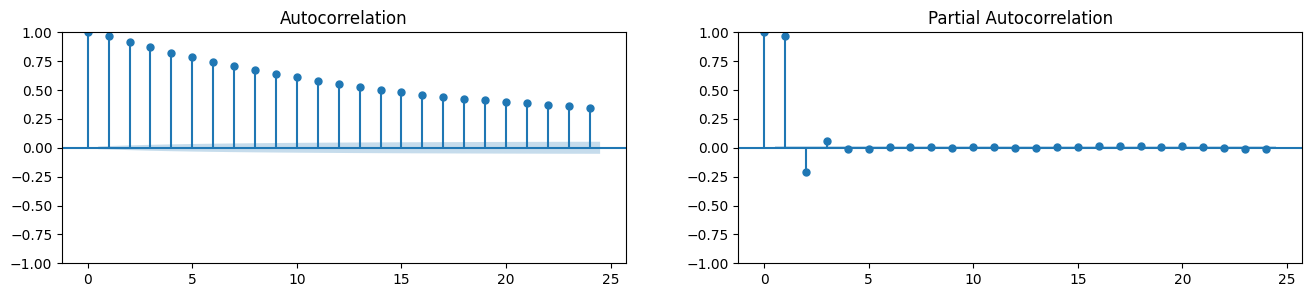

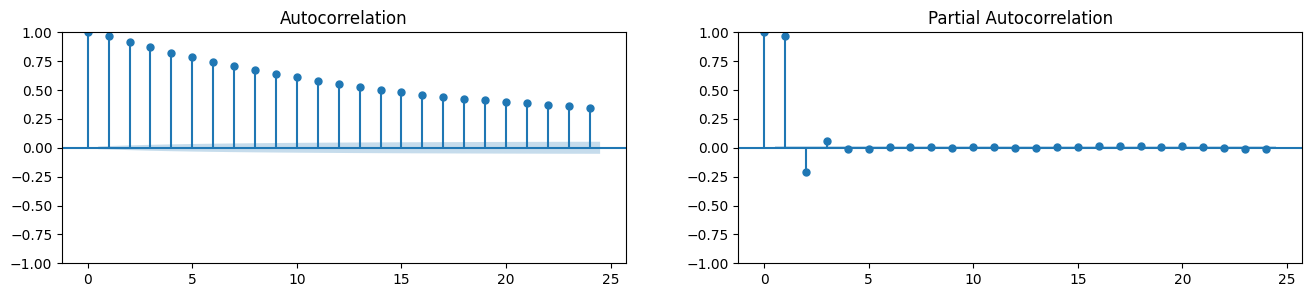

In [26]:



fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_df[target], lags=24, ax=axes[0])
plot_pacf(train_df[target], lags=24, ax=axes[1])

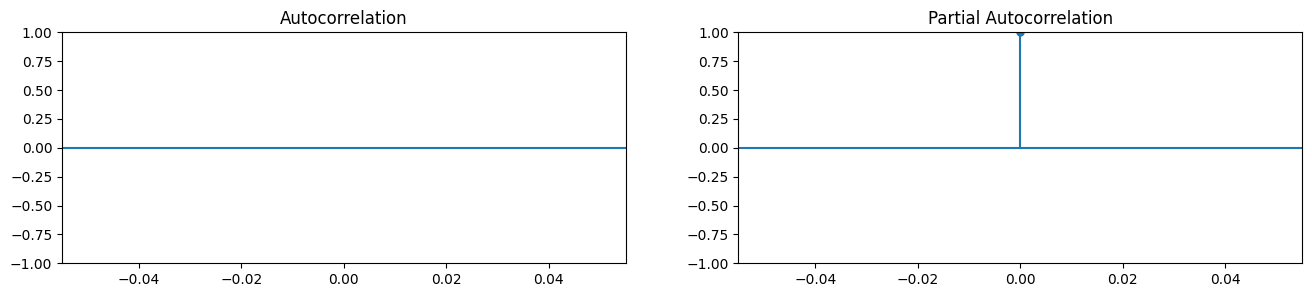

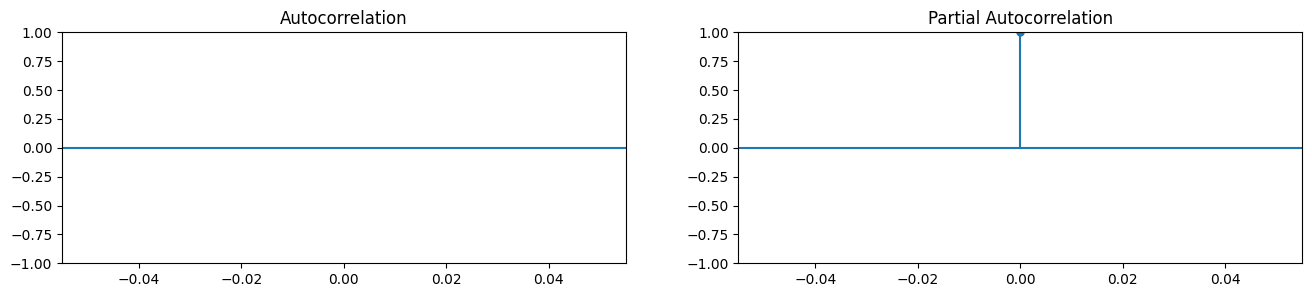

In [27]:



fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_df[target].diff(), lags=24, ax=axes[0])
plot_pacf(train_df[target].diff(), lags=24, ax=axes[1])